# Assignment 3

- Go back to Lab assignment 2 and improve the LR result based on the extensions of LR
- Classify the weakest link based on the 38 predictors of a movement using a few classification variants(different models or model parameterizations)
- Select an accuracy metric
- Test and iteratively improve the accuracy of the variants

## Imports

In [19]:
import sys

sys.path.append("../../scripts")

import dagshub
import mlflow
import ML_utils as MLUtils

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier



## Setup

In [ ]:
# Setup dagshub and MLFlow

dagshub.init(repo_owner="SamuelFredricBerg", repo_name="4dt907", mlflow=True)
utils = MLUtils.MLUtils("Project_Model_A3")

# Configs
config = {
    "data_split_seed": 42,
    "test_size": 0.2,
    "n_folds": 10,
    "shuffle": True,
    "variant": "A3-Configurations",
    
    "learning_rate": 0.1,
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 5,
    "class_weight": "balanced",
}

WeakLink_data_path = "../../data/AimoScore_WeakLink_big_scores_A3.csv"
Scores_data_path = "../../data/scores_and_weak_links_A3.csv"

dfw = pd.read_csv(WeakLink_data_path)
dfs = pd.read_csv(Scores_data_path)


df_final = pd.merge(dfw, dfs, on="ID")


weak_link_columns = [
    'ForwardHead', 'LeftArmFallForward', 'RightArmFallForward',
    'LeftShoulderElevation', 'RightShoulderElevation', 'ExcessiveForwardLean',
    'LeftAsymmetricalWeightShift', 'RightAsymmetricalWeightShift',
    'LeftKneeMovesInward', 'RightKneeMovesInward', 'LeftKneeMovesOutward',
    'RightKneeMovesOutward', 'LeftHeelRises', 'RightHeelRises'
]

# Create the target label
df_final['WeakestLink'] = df_final[weak_link_columns].idxmax(axis=1)

print("How many of each weak link??")
print(df_final['WeakestLink'].value_counts())


kf = KFold(
    n_splits=config["n_folds"],
    shuffle=config["shuffle"],
    random_state=config["data_split_seed"],
)

Initialized MLflow to track repo "SamuelFredricBerg/4dt907"

Repository SamuelFredricBerg/4dt907 initialized!

How many of each weak link??
LeftArmFallForward              630
RightArmFallForward             472
RightKneeMovesOutward           277
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: WeakestLink, dtype: int64


# Preprocessing

In [21]:
def preprocessing(df):
    df_cleaned = df
    return df_cleaned

# Plots

In [22]:
def confuse_matrix(X, y, model):
    # 1. Train on a single split to see real predictions
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 2. Create the plot
    # 1. Define the full list of expected labels (from your earlier definition)
    all_labels = weak_link_columns 

    # 2. Create the plot with the 'labels' argument
    fig, ax = plt.subplots(figsize=(12, 10)) # Made slightly larger for 14 labels
    ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred, 
        ax=ax, 
        display_labels=all_labels, # Force these labels on the axes
        labels=all_labels,         # Ensure it looks for all 14
        cmap='Blues', 
        xticks_rotation=90
    )
    plt.title("Weakest Link Prediction: 14-Class Matrix")
    plt.tight_layout() # Prevents label cutoff
    plt.savefig("matrix.png")
    plt.show()

In [23]:
def crossval_boxplots(f1_raw, acc_raw, prec_raw, rec_raw):
    # 1. Create a dictionary of the raw arrays
    raw_data = {
        'F1 Score': f1_raw,
        'Accuracy': acc_raw,
        'Precision': prec_raw,
        'Recall': rec_raw
    }
    
    # 2. Convert to 'Long Format' (This is why your plot was likely clamped)
    df_plot = pd.DataFrame(raw_data).melt(var_name='Metric', value_name='Score')
    
    # 3. Plotting
    plt.figure(figsize=(10, 6))
    
    # Setting the style to whitegrid helps readability
    sns.set_style("whitegrid")
    
    # Use 'Metric' for x and 'Score' for y
    ax = sns.boxplot(x='Metric', y='Score', data=df_plot, palette="Set3", width=0.4)
    sns.swarmplot(x='Metric', y='Score', data=df_plot, color=".25", size=7)

    # 4. Smart Scaling: Instead of 0 to 1, let's zoom in on the data 
    # but keep a little padding so we can see the whiskers
    ymin = df_plot['Score'].min() - 0.05
    ymax = df_plot['Score'].max() + 0.05
    plt.ylim(max(0, ymin), min(1, ymax)) # Ensure we don't go out of 0-1 range
    
    plt.title(f'Model Stability: {config["variant"]}\n(Zoomed in to show variance)')
    plt.ylabel('Score Value')
    
    plt.savefig("boxplot.png")
    plt.show()

## Main Code

Model Done
Fitting done
No_12_NASM_Deviation     0.177502
No_8_NASM_Deviation      0.088649
No_7_NASM_Deviation      0.067628
No_9_NASM_Deviation      0.059131
No_10_NASM_Deviation     0.051130
No_6_Angle_Deviation     0.038685
No_6_NASM_Deviation      0.034270
No_3_Angle_Deviation     0.031688
No_17_NASM_Deviation     0.029801
No_2_NASM_Deviation      0.025224
No_12_Angle_Deviation    0.024616
No_8_Angle_Deviation     0.024560
No_25_NASM_Deviation     0.021211
No_9_Angle_Deviation     0.019695
No_1_NASM_Deviation      0.018993
No_5_Angle_Deviation     0.018126
No_7_Angle_Deviation     0.017057
No_2_Time_Deviation      0.016995
No_2_Angle_Deviation     0.015234
No_11_NASM_Deviation     0.015200
No_4_Angle_Deviation     0.015180
No_16_NASM_Deviation     0.014075
No_14_NASM_Deviation     0.014053
No_18_NASM_Deviation     0.013355
No_19_NASM_Deviation     0.012840
No_13_NASM_Deviation     0.012360
No_1_Time_Deviation      0.012262
No_23_NASM_Deviation     0.011187
No_11_Angle_Deviation   

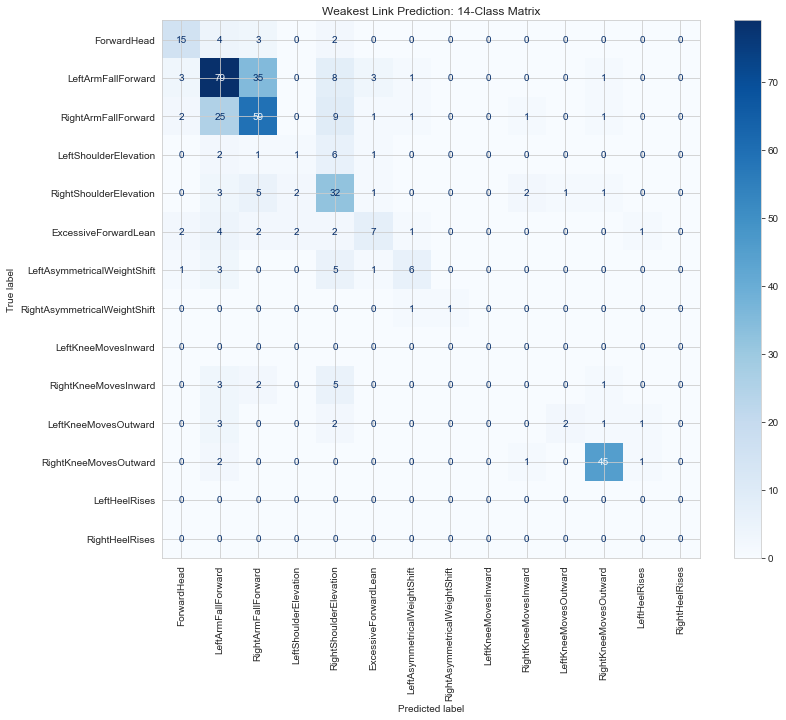

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.9/site-packag

{'F1_Mean': 0.5952913139447029, 'F1_Std': 0.02568417393672342, 'Accuracy_Mean': 0.6093665983139669, 'Precision_Mean': 0.6084530903147225, 'Recall_Mean': 0.6093665983139669}


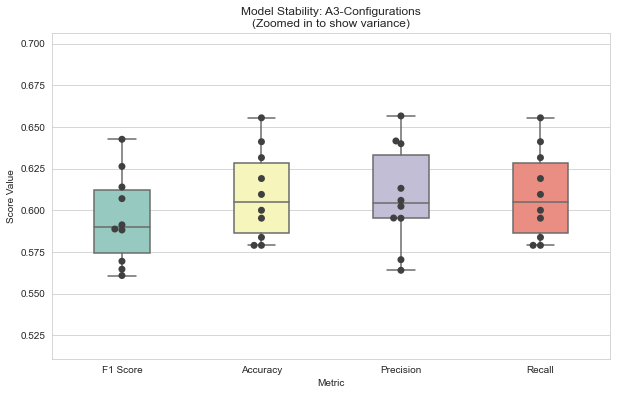

New Best! 0.5952913139447029 > 0.5942669866732416. Updating models on DagsHub
Deleting old backup model.


2026/02/09 14:09:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/09 14:09:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/9w/6516vw7x2gbc3llv8dbzm6vw0000gn/T/tmp31cdjepv/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/02/09 14:09:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Project_Model_A3' already exists. Creating a new version of this model...
2026/02/09 14:09:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Project_Model_A3, version 12
Created version '12' of model 'Project_Model_A3'.
/var/folders/9w/6516vw7x2gbc3llv

New model beat current @dev uploading to DagsHub
🏃 View run A3-Training-GBC at: https://dagshub.com/SamuelFredricBerg/4dt907.mlflow/#/experiments/0/runs/5ee6b716ec2e488e8e24576ed749c80a
🧪 View experiment at: https://dagshub.com/SamuelFredricBerg/4dt907.mlflow/#/experiments/0


In [24]:

with mlflow.start_run(run_name="A3-Training-GBC") as run:
    mlflow.log_params(config)


    y = df_final['WeakestLink']
    cheating_cols = weak_link_columns + [
    'WeakestLink', 'ID', 'Date', 'SCORE', 'AimoScore', 
    'EstimatedScore', 'label score'
    ]

    X = df_final.drop(columns=[c for c in cheating_cols if c in df_final.columns], errors='ignore')

    # 3. Ensure we only have numeric sensor data
    X = X.select_dtypes(include=[np.number])

    # model = RandomForestClassifier(
    #     n_estimators=config["n_estimators"],
    #     max_depth=config["max_depth"],
    #     min_samples_split=config["min_samples_split"],
    #     random_state=config["data_split_seed"],
    #     class_weight=config["class_weight"],
    #     min_samples_leaf=config["min_samples_leaf"],
    # )
    model = GradientBoostingClassifier(
        n_estimators=config["n_estimators"],
        learning_rate=config["learning_rate"], 
        max_depth=config["max_depth"],
        random_state=config["data_split_seed"]
    )

    print("Model Done")

    model.fit(X,y)

    print("Fitting done")

    importances = pd.Series(model.feature_importances_, index=X.columns)
    # Look for features with importance near 0.00
    print(importances.sort_values(ascending=False))

    confuse_matrix(X, y, model)


    f1_scores = cross_val_score(model, X, y, cv=kf, scoring='f1_weighted')
    accuracy = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=kf, scoring='precision_weighted')
    recall = cross_val_score(model, X, y, cv=kf, scoring='recall_weighted')

    results = {
        "F1_Mean": f1_scores.mean(),
        "F1_Std": f1_scores.std(),
        "Accuracy_Mean": accuracy.mean(),
        "Precision_Mean": precision.mean(),
        "Recall_Mean": recall.mean()
    }
    print(results)

    crossval_boxplots(f1_scores,accuracy,precision,recall)

    mlflow.log_metrics(results)

    mlflow.log_artifact("boxplot.png")
    mlflow.log_artifact("matrix.png")

    if utils.auto_check_challenger(run.info.run_id, metric_name="F1_Mean"):
        mlflow.sklearn.log_model(model, "model", registered_model_name="Project_Model_A3")
        latest_v = utils.client.get_latest_versions("Project_Model_A3")[0].version
        utils.client.set_registered_model_alias("Project_Model_A3", "dev", latest_v)
        print("New model beat current @dev uploading to DagsHub")
    else:
        print("Did not beat current @dev, model not uploaded to Dagshub")